In [18]:
import pandas as pd
import numpy as np
import seaborn as sns
from pmdarima import auto_arima
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error, mean_absolute_error
from statsmodels.graphics.gofplots import qqplot
from statsmodels.graphics.tsaplots import plot_acf

In [19]:
file_path = "CSV/Passatgers.csv"
df = pd.read_csv(file_path)

print(df.head())

           ds       y
0  1978-01-01  381224
1  1978-02-01  356039
2  1978-03-01  499520
3  1978-04-01  496170
4  1978-05-01  633790


In [20]:
# Convertir la columna 'ds' a tipo datetime
df['ds'] = pd.to_datetime(df['ds'])

# Establecer la columna 'ds' como el índice del DataFrame
df.set_index('ds', inplace=True)

print(df.head())

                 y
ds                
1978-01-01  381224
1978-02-01  356039
1978-03-01  499520
1978-04-01  496170
1978-05-01  633790


In [21]:
model = auto_arima(df, seasonal=True, m=12)  # m=12 para capturar la estacionalidad anual
print(model.summary())

                                     SARIMAX Results                                      
Dep. Variable:                                  y   No. Observations:                  392
Model:             SARIMAX(1, 1, 0)x(2, 1, 0, 12)   Log Likelihood               -4757.026
Date:                            Wed, 12 Jun 2024   AIC                           9522.052
Time:                                    19:17:54   BIC                           9537.802
Sample:                                01-01-1978   HQIC                          9528.302
                                     - 08-01-2010                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.2827      0.045     -6.298      0.000      -0.371      -0.195
ar.S.L12      -0.4844      0.039   

In [22]:
# Dividir los datos en conjunto de entrenamiento y conjunto de prueba
train_size = int(len(df) * 0.8)  # Proporción del 80% para entrenamiento
train_data = df[:train_size]
test_data = df[train_size:]

p=1
d=1
q=0
P=2
D=1
Q=0
m=12

# Ajustar el modelo SARIMA al conjunto de entrenamiento
model = SARIMAX(train_data, order=(p, d, q), seasonal_order=(P, D, Q, m)).fit()


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.17669D+01    |proj g|=  7.54611D-02


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate    5    f=  1.17595D+01    |proj g|=  2.41229D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4      5      7      1     0     0   2.412D-06   1.176D+01
  F =   11.759495671826919     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


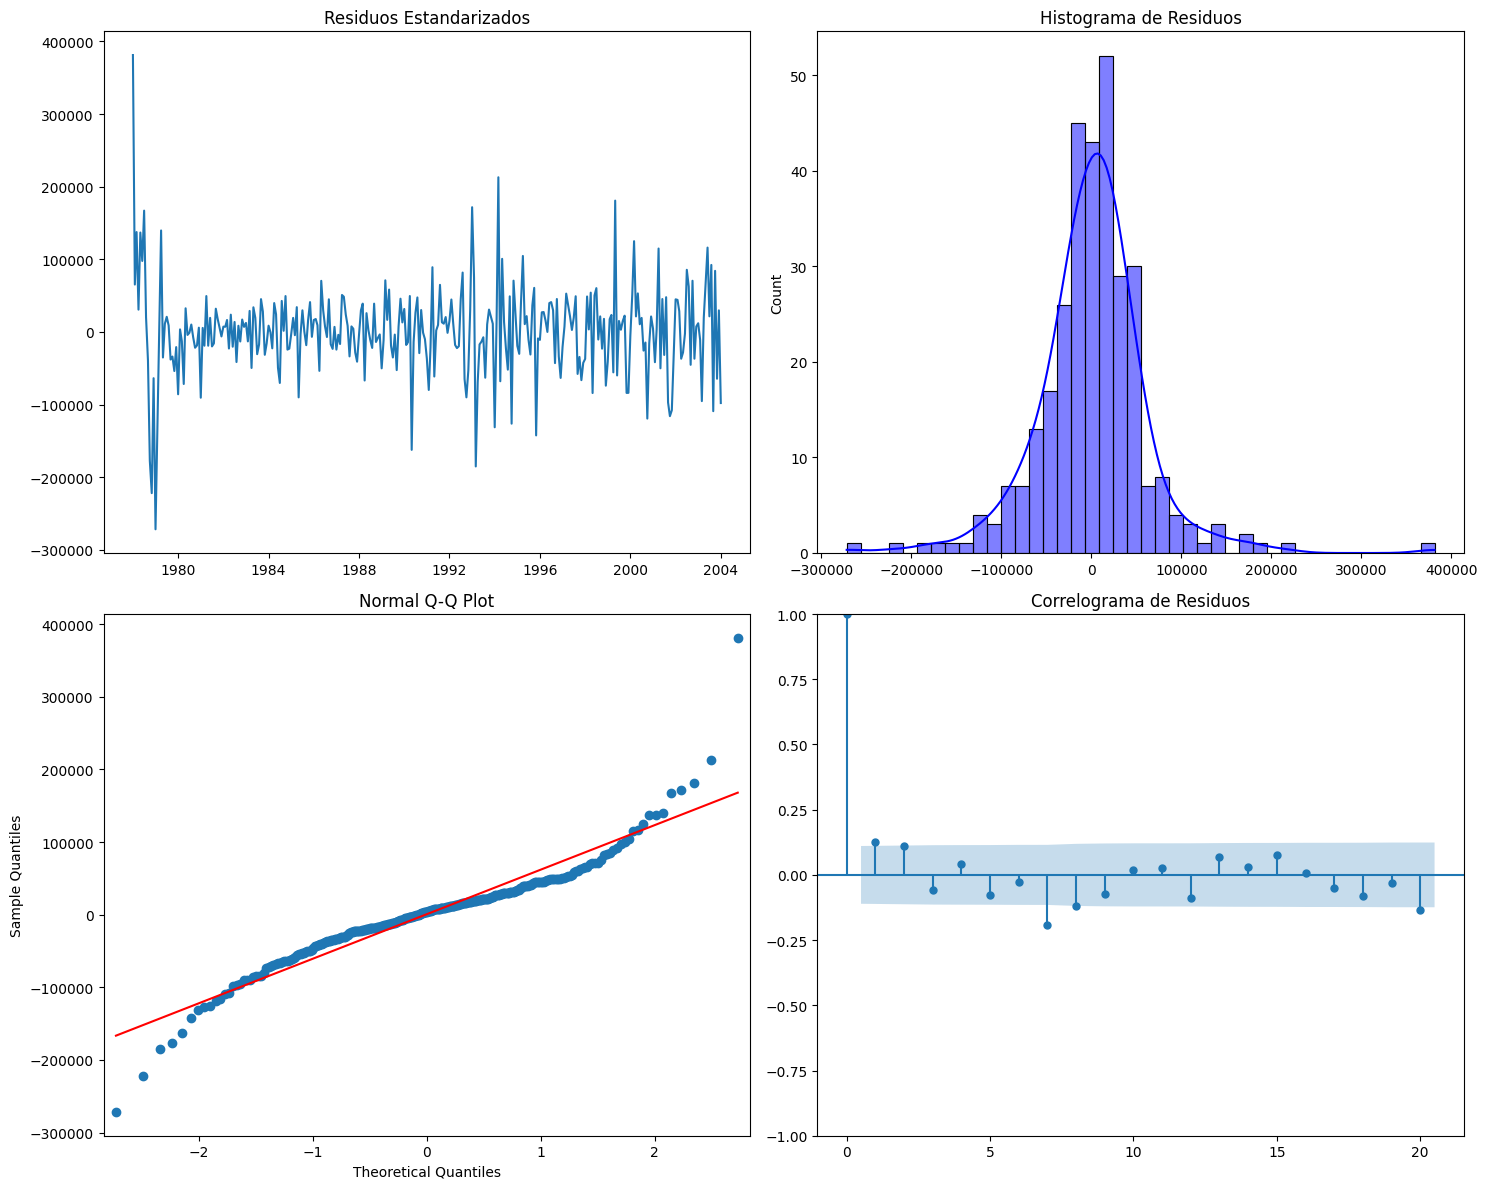

In [23]:
# Obtener los residuos del modelo
residuals = model.resid

# Crear subgráficos
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(15, 12))

# Gráfico de residuos estandarizados
axes[0, 0].plot(residuals)
axes[0, 0].set_title('Residuos Estandarizados')

# Histograma comparado con la normal
sns.histplot(residuals, kde=True, color='blue', ax=axes[0, 1])
axes[0, 1].set_title('Histograma de Residuos')

# Normal Q-Q plot
qqplot(residuals, line='s', ax=axes[1, 0])
axes[1, 0].set_title('Normal Q-Q Plot')

# Correlograma de los residuos
plot_acf(residuals, lags=20, ax=axes[1, 1])
axes[1, 1].set_title('Correlograma de Residuos')

plt.tight_layout()
plt.show()

In [24]:
# Pronósticos del modelo en el conjunto de prueba
predictions = model.predict(start=len(train_data), end=len(train_data)+len(test_data)-1, dynamic=False)

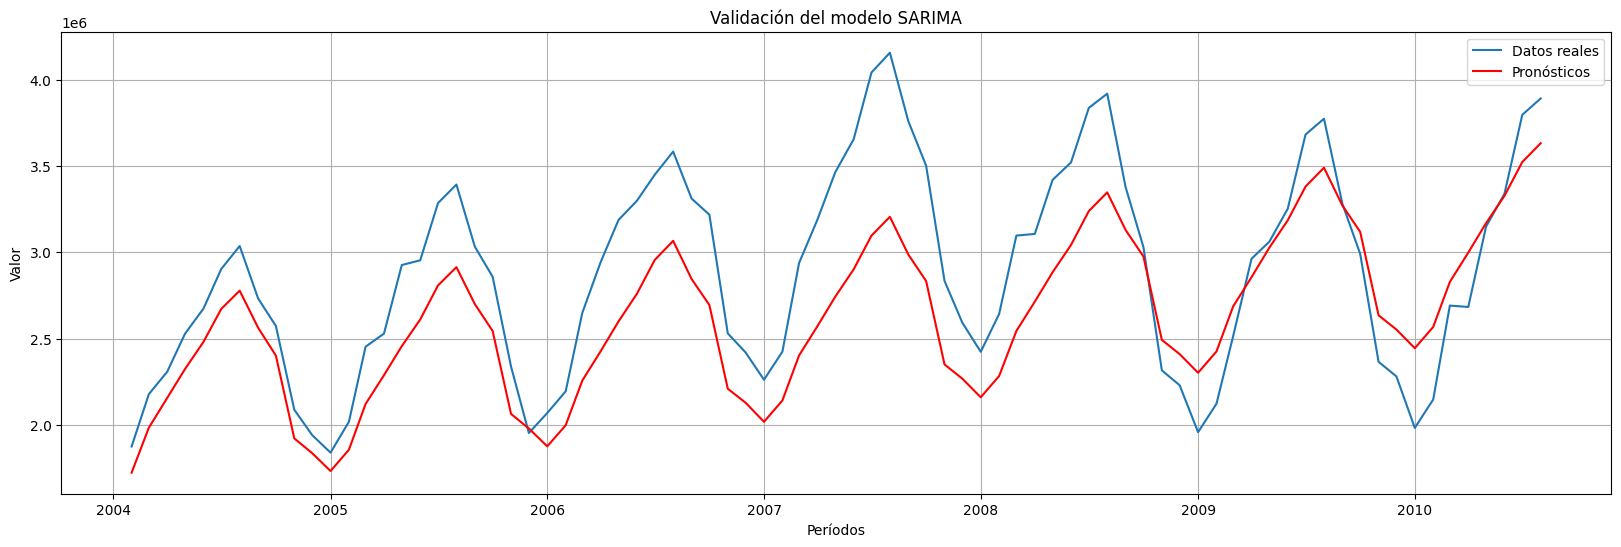

In [25]:
# Gráfico de pronósticos vs datos reales
plt.figure(figsize=(20, 6))
plt.plot(test_data, label='Datos reales')
plt.plot(predictions, color='red', label='Pronósticos')
plt.title('Validación del modelo SARIMA')
plt.xlabel('Períodos')
plt.ylabel('Valor')
plt.legend()
plt.grid(True)
plt.show()